In [99]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder

## Dataset analysis

This part of the notebook follows, in part, [this tutorial](https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem/notebook). Head over there to read the explanations.

I also diverged and did some analysis on my own (such as data imbalancing analysis).

In [100]:
df = pd.read_csv("data/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Fixing string data type

In [101]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [102]:
string_col = df.select_dtypes(include="object").columns
df[string_col] = df[string_col].astype("string")

In [103]:
df.dtypes

Age                 int64
Sex                string
ChestPainType      string
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         string
MaxHR               int64
ExerciseAngina     string
Oldpeak           float64
ST_Slope           string
HeartDisease        int64
dtype: object

### Categorical columns

In [104]:
cat_cols = df.select_dtypes(include="string").columns

In [105]:
num_cols = df.columns.to_list()
for col in cat_cols:
    num_cols.remove(col)
num_cols.remove("HeartDisease") # remove target variable

In [106]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### Exploratory Analysis

In [107]:
fig=px.histogram(df, 
                 x="HeartDisease",
                 hover_data=df.columns,
                 title="Distribution of Positive and Negative classes",
                 barmode="group")

fig.show()

Both classes have roughly the same number of examples - let's consider it balanced.

In [108]:
px.imshow(df.corr(),title="Correlation Matrix")

Correlations are mostly negative, but there are some very strong ones:
- MaxHR and HeartDisease;
- MaxHR and Age;
- Cholesterol and FastingBS;
- Cholesterol and HeartDisease;

A meaningful positive correlation is also found between OldPeak and HeartDisease.

### Gender

In [109]:
fig=px.histogram(df, 
                 x="HeartDisease",
                 color="Sex",
                 hover_data=df.columns,
                 title="Distribution of Heart Diseases",
                 barmode="group")
fig.show()

In [110]:
classes_gendered = df.groupby(['Sex', 'HeartDisease']).size().unstack()
classes_count = df.groupby(['Sex']).size()
classes_ratios = classes_gendered.div(classes_count, axis=0)
classes_ratios

HeartDisease,0,1
Sex,,
F,0.740933,0.259067
M,0.368276,0.631724


Men are much more likely to have heart failure than women.

### Chest Pain

In [111]:
fig=px.histogram(df,
                 x="ChestPainType",
                 color="Sex",
                 hover_data=df.columns,
                 title="Types of Chest Pain"
                )
fig.show()

Chest pain is also more common among men. However, most entries asymptomatic.

In [112]:
px.histogram(df, x="HeartDisease", color="ChestPainType", title="Types of Chest Pain", barmode="group")

In [113]:
# combine all the chest pain types into 2 categories
symptomatic = df.copy()
symptomatic["ChestPainType"] = symptomatic["ChestPainType"].replace(["TA","ATA","NAP","ASY"], ["symptomatic","symptomatic","symptomatic","asymptomatic"])
px.histogram(symptomatic, x="HeartDisease", color="ChestPainType", title="Types of Chest Pain", barmode="group")

Given that the objective to predict heart failure early, it is important to note that most heart failures happen with no prior evidence of chest pain. However, there are about 3 times more heart failures for people with Non-Anginal chest pain than for other chest pain types.

### Resting ECG

In [114]:
fig=px.histogram(df,
                 x="RestingECG",
                 color="HeartDisease",
                 hover_data=df.columns,
                 title="Distribution of Resting ECG",
                 barmode="group")
fig.show()

Most people have normal resting ECG. However, there are more heart failures among people with ST-T wave abnormality than among people with left ventricular hypertrophy. This is interesting, as the latter is a sign of heart failure.

Nevertheless, the difference between classes is not very significant. This feature may not be very useful.

### Multiple Bi-Variate Analysis

[]

<Figure size 1500x1000 with 0 Axes>

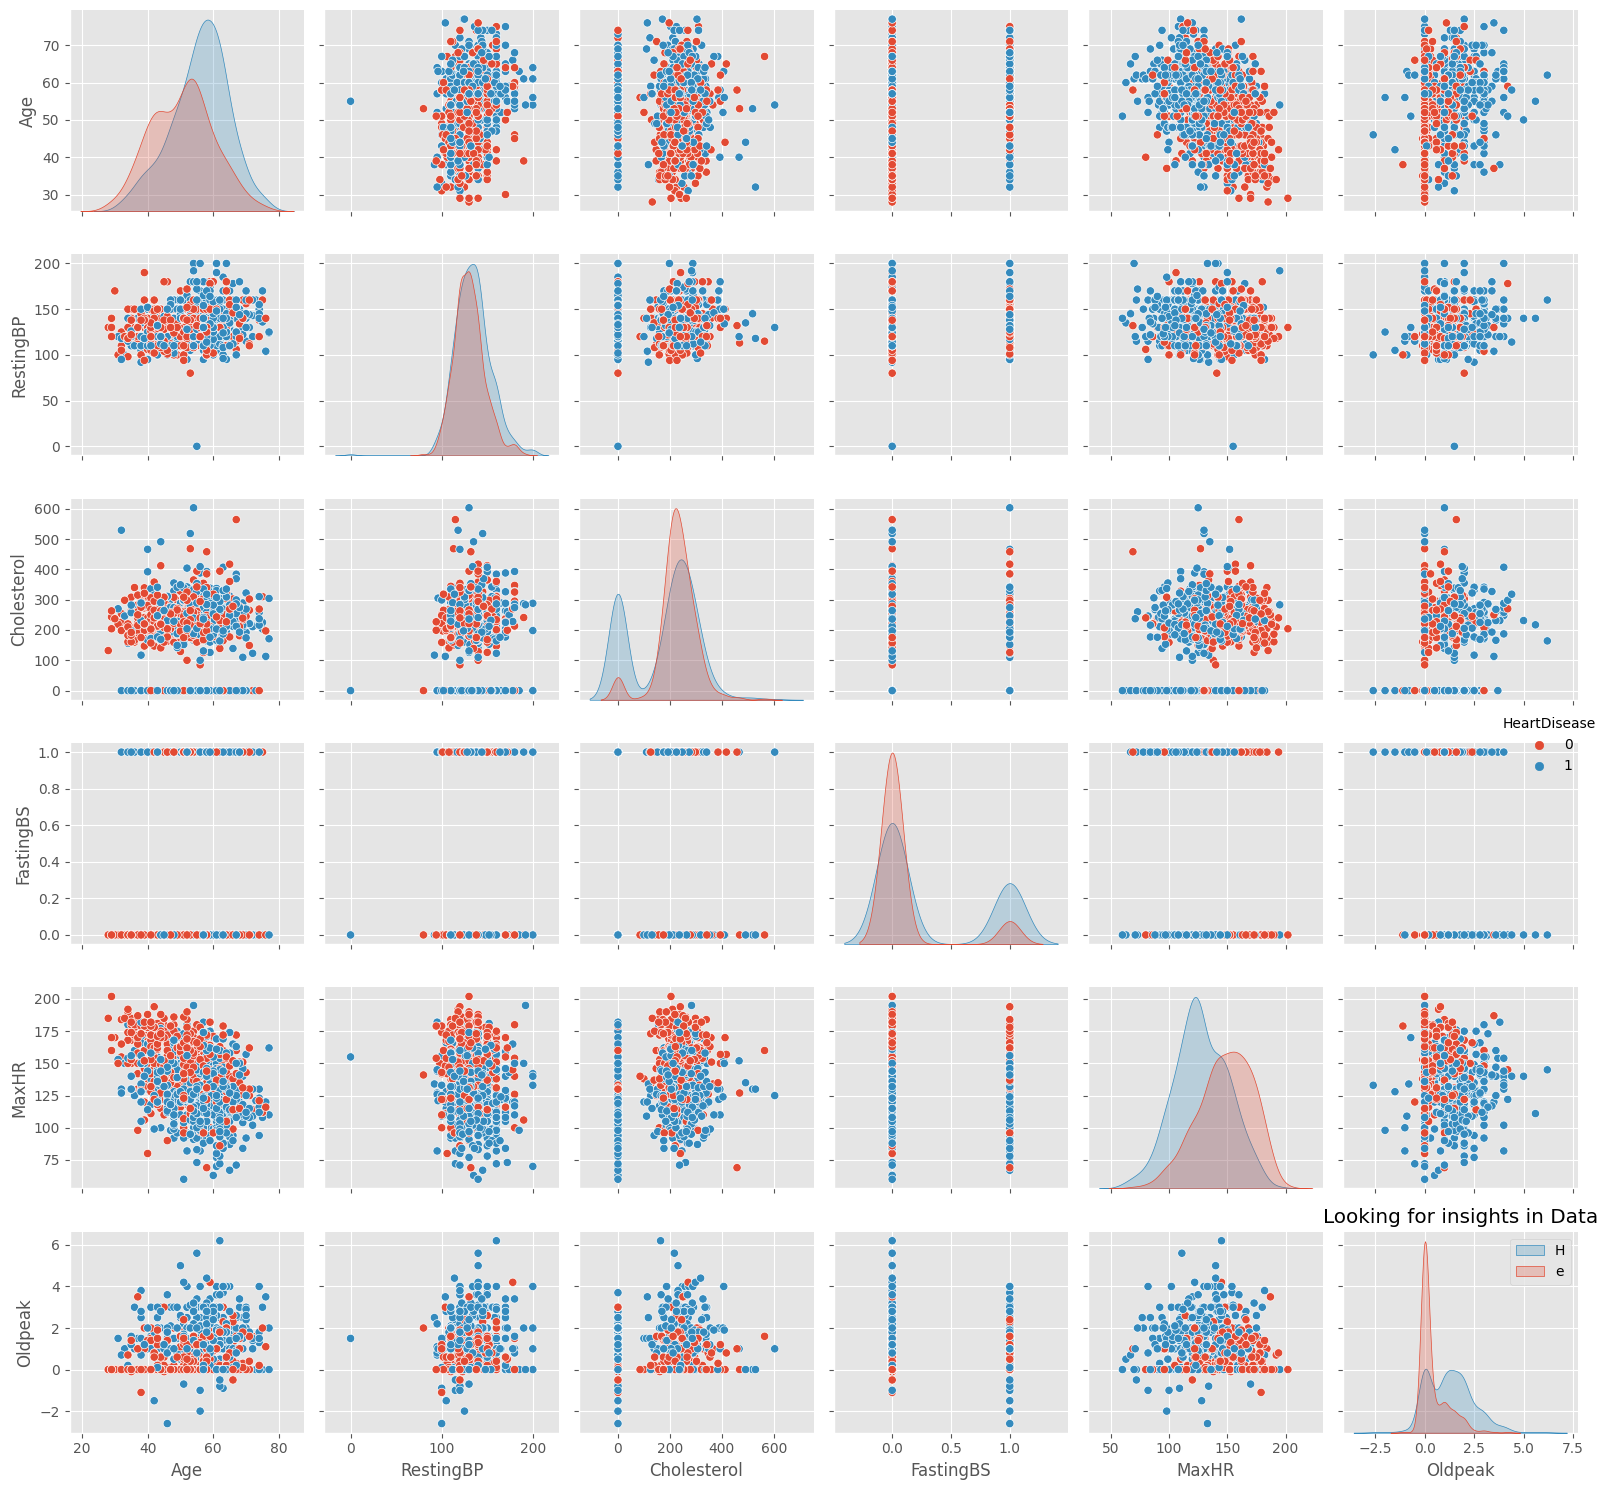

In [115]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for insights in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

### Variable Distribution

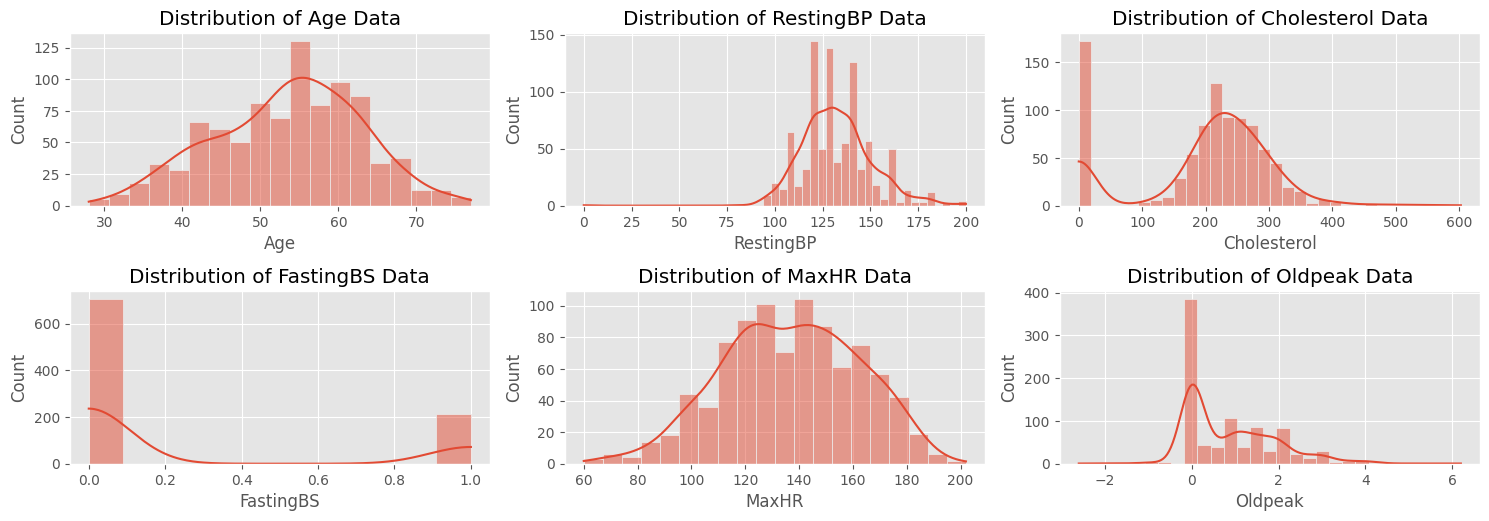

In [116]:
plt.figure(figsize=(15,10))
for i,col in enumerate(num_cols,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

### Outliers

In [117]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=3, subplot_titles=num_cols)


for i,col in enumerate(num_cols,1):
    plot_row = (i-1)//3 + 1
    plot_col = i - 3*(plot_row-1)
    fig.add_trace(
        go.Box(x=df["HeartDisease"],y=df[col],name=col),
        row=plot_row,
        col=plot_col
    )


fig.update_layout(height=800, width=800, title_text="Side By Side Subplots")
fig.show()

## Data Preprocessing

In [118]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No missing values were found.

### Cholesterol

The cholesterol variable has a lot of 0 values. This is probably due to the fact that the cholesterol was not measured. Let's replace these values with the median of the variable.

In [119]:
def replace_cholesterol_with_median(df):
    # replace 0 values with values around the median
    df["Cholesterol"] = df["Cholesterol"].replace(0, df["Cholesterol"].median())
    return df

df_copy = df.copy()
df_copy = replace_cholesterol_with_median(df_copy)
# plot the distribution of cholesterol
px.histogram(df_copy, x="Cholesterol", title="Distribution of Cholesterol")

### Normalization

In [120]:
def standardize(df, target_col=None):
    scaler = preprocessing.StandardScaler()
    if target_col:
        y = df[target_col]
        df.drop(target_col,axis=1,inplace=True)
    numerical_columns = df.columns.to_list()
    categorical_columns = df.select_dtypes(include="string").columns
    for col in categorical_columns:
        numerical_columns.remove(col)
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    if target_col:
        df = pd.concat([df,y],axis=1)
    return df

df_copy = df.copy()
df_copy = standardize(df_copy, "HeartDisease")
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,-1.083616e-16,1.000545,-2.706015,-0.690629,0.051881,0.688318,2.491558
RestingBP,918.0,1.954380e-16,1.000545,-7.154995,-0.669935,-0.129513,0.410909,3.653439
Cholesterol,918.0,0.000000e+00,1.000545,-1.818435,-0.233704,0.221363,0.623835,3.697252
FastingBS,918.0,-3.096047e-17,1.000545,-0.551341,-0.551341,-0.551341,-0.551341,1.813758
MaxHR,918.0,4.953675e-16,1.000545,-3.018469,-0.660578,0.046790,0.754157,2.561874
Oldpeak,918.0,1.238419e-16,1.000545,-3.271482,-0.832432,-0.269575,0.574711,4.983762
HeartDisease,918.0,5.533769e-01,0.497414,0.000000,0.000000,1.000000,1.000000,1.000000


### Handling Categorical Data

In [121]:
def categorical_to_onehot(df):
    categorical_columns = df.select_dtypes(include="string").columns
    df = pd.get_dummies(df, columns=categorical_columns,drop_first=False)
    return df

df_copy = df.copy()
df_copy = categorical_to_onehot(df_copy)
df_copy.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [122]:
# df_copy = standardize(df_copy, "HeartDisease")
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0
Sex_F,918.0,0.210240,0.407701,0.0,0.00,0.0,0.0,1.0
Sex_M,918.0,0.789760,0.407701,0.0,1.00,1.0,1.0,1.0
ChestPainType_ASY,918.0,0.540305,0.498645,0.0,0.00,1.0,1.0,1.0


### Preprocessing Pipeline

In [123]:
def preprocess(df, target_col=None):
    df = replace_cholesterol_with_median(df)
    df = standardize(df, target_col)
    df = categorical_to_onehot(df)
    return df

df_copy = df.copy()
df_copy = preprocess(df_copy, "HeartDisease")
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,-1.083616e-16,1.000545,-2.706015,-0.690629,0.051881,0.688318,2.491558
RestingBP,918.0,1.954380e-16,1.000545,-7.154995,-0.669935,-0.129513,0.410909,3.653439
Cholesterol,918.0,-3.483053e-17,1.000545,-2.883623,-0.492677,-0.325867,0.489649,6.717227
FastingBS,918.0,-3.096047e-17,1.000545,-0.551341,-0.551341,-0.551341,-0.551341,1.813758
MaxHR,918.0,4.953675e-16,1.000545,-3.018469,-0.660578,0.046790,0.754157,2.561874
Oldpeak,918.0,1.238419e-16,1.000545,-3.271482,-0.832432,-0.269575,0.574711,4.983762
HeartDisease,918.0,5.533769e-01,0.497414,0.000000,0.000000,1.000000,1.000000,1.000000
Sex_F,918.0,2.102397e-01,0.407701,0.000000,0.000000,0.000000,0.000000,1.000000
Sex_M,918.0,7.897603e-01,0.407701,0.000000,1.000000,1.000000,1.000000,1.000000
ChestPainType_ASY,918.0,5.403050e-01,0.498645,0.000000,0.000000,1.000000,1.000000,1.000000


## Model Selection, Training and Evaluation

In [124]:
import keras
from sklearn.model_selection import train_test_split

### Test-Train Split

In [549]:
processed_df = preprocess(df.copy(), "HeartDisease")
X_train, X_test, y_train, y_test = train_test_split(processed_df.drop("HeartDisease",axis=1), processed_df["HeartDisease"], test_size=0.3, random_state=4)

In [550]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((642, 20), (276, 20), (642,), (276,))

### Model Selection

In [780]:
model = keras.Sequential([
    keras.layers.Dense(200, activation="linear", input_shape=(X_train.shape[1],)),
    keras.layers.ELU(),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(100, activation="linear"),
    keras.layers.ELU(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(50, activation="linear"),
    keras.layers.ELU(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(25, activation="linear"),
    keras.layers.ELU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

optimizer = keras.optimizers.Nadam(learning_rate=1e-4, decay=1e-7)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_581 (Dense)           (None, 200)               4200      
                                                                 
 elu_36 (ELU)                (None, 200)               0         
                                                                 
 dropout_300 (Dropout)       (None, 200)               0         
                                                                 
 dense_582 (Dense)           (None, 100)               20100     
                                                                 
 elu_37 (ELU)                (None, 100)               0         
                                                                 
 dropout_301 (Dropout)       (None, 100)               0         
                                                                 
 dense_583 (Dense)           (None, 50)             

### Model Training

In [781]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=100, shuffle=True)

Epoch 1/100
7/7 [==============================] - 2s 51ms/step - loss: 0.8128 - accuracy: 0.5374 - val_loss: 0.5993 - val_accuracy: 0.7536
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.8045 - accuracy: 0.5498 - val_loss: 0.5764 - val_accuracy: 0.7790
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7740 - accuracy: 0.5654 - val_loss: 0.5545 - val_accuracy: 0.7971
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7657 - accuracy: 0.5794 - val_loss: 0.5338 - val_accuracy: 0.8007
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7587 - accuracy: 0.5498 - val_loss: 0.5126 - val_accuracy: 0.8116
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.7202 - accuracy: 0.6090 - val_loss: 0.4942 - val_accuracy: 0.8152
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.7355 - accuracy: 0.5810 - val_loss: 0.4783 - val_accuracy: 0.8225
Epoch 8/100
7/7 [===

### Model Evaluation

In [782]:
model.evaluate(X_train, y_train)

21/21 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8520


[0.3659672439098358, 0.8520249128341675]

In [783]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.2912 - accuracy: 0.8913


[0.2912215292453766, 0.8913043737411499]

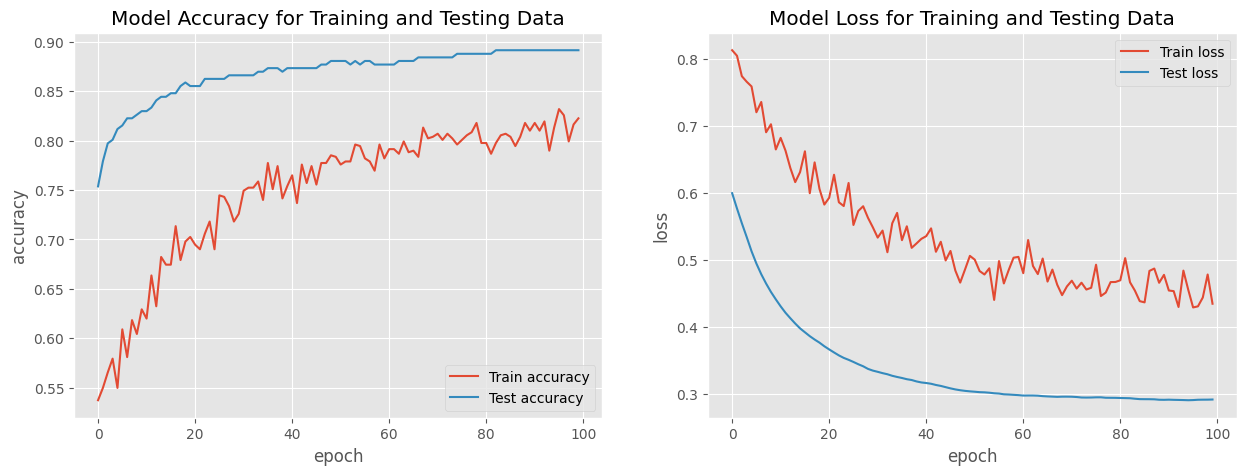

In [795]:
# Plot the training and validation accuracy and loss at each epoch
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy for Training and Testing Data')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for Training and Testing Data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.show()

## Conclusions

The model was able to achieve an accuracy of 89.13% on the test set. This is a good result, but it is not the best possible.

This could be due to a number of reasons:
- The dataset is small;
- The data could be better processed (e.g., we could have runned a PCA to reduce the number of features, or we could have used a different normalization method);
- The model could be better tuned (e.g., a lot of hyperparameters were not tuned).
- And so on.

Nevertheless, the model is able to predict heart failure with a good accuracy. I'm quite happy with the result.